# Imports

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model

2025-03-16 16:39:36.243077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742143176.264714   37142 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742143176.270469   37142 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 16:39:36.297116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train on single vehicle dynamics (inverse problem)

In [3]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m 
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
    
        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""
        
        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)
        

        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)
        
        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)
        
        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])
    

## Generate synthetic data

In [4]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
x0 = (0, 20/3.6) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp = np.array([0.5, 0.4, 0.35, 0.35, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

## Simulate measurements (add noise)

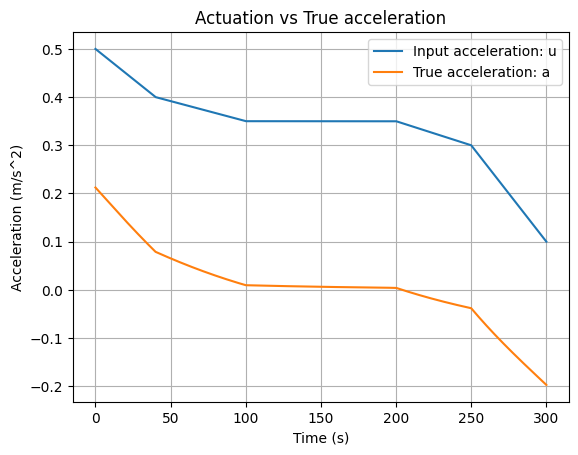

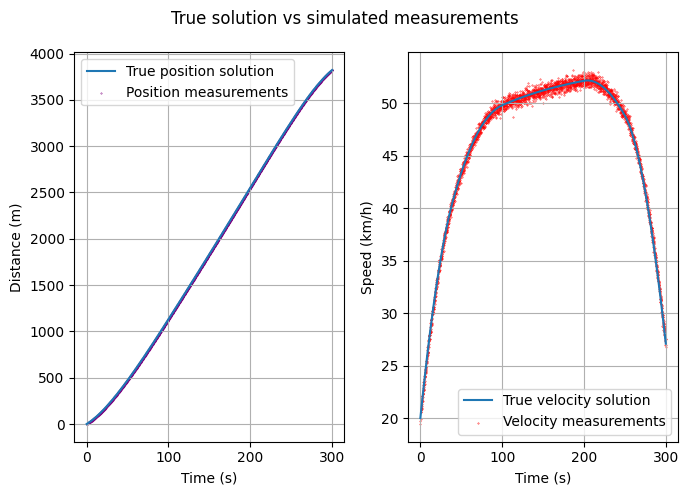

In [5]:
variance = 0.1

x_true = np.array(car.history["x"]).reshape(-1, 1)
v_true = np.array(car.history["v"]).reshape(-1, 1)
X_true = np.hstack((x_true, v_true))
X_noise = X_true + np.random.normal(0, variance, size=X_true.shape)

plt.plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
plt.plot(t, car.history["a"], label="True acceleration: a")
plt.title("Actuation vs True acceleration")
plt.grid()
plt.legend();
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
fig = plt.figure(figsize=(7,5))
fig.suptitle("True solution vs simulated measurements")
ax=fig.subplots(1,2)
ax[0].plot(t, X_true[:, 0], label="True position solution")
ax[0].scatter(t, X_noise[:, 0], label="Position measurements", s=0.1, color="purple")
ax[0].set_ylabel("Distance (m)")
ax[1].plot(t, X_true[:, 1]*3.6, label="True velocity solution")
ax[1].scatter(t, X_noise[:, 1]*3.6, label="Velocity measurements", s=0.1, color="red")
ax[1].set_ylabel("Speed (km/h)")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
fig.tight_layout()

## Forward Problem

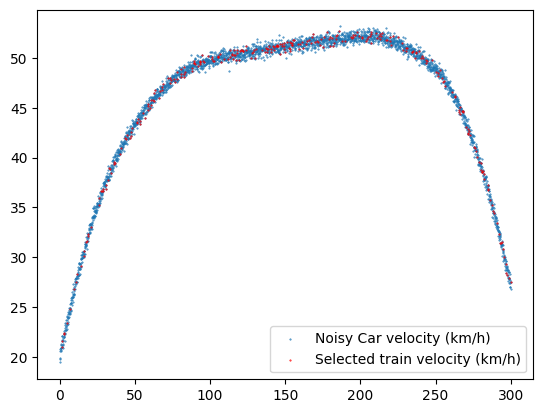

In [46]:
train_ratio = .1
X_train, _, t_train, _ = train_test_split(X_noise, t, train_size=train_ratio, random_state=31)
#print(X_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(t, t_train)
X_mask = X_noise.copy()
X_mask[~mask] = np.nan
plt.scatter(t, X_noise[:, 1] * 3.6, label="Noisy Car velocity (km/h)", s=.2)
plt.scatter(t, X_mask[:, 1] * 3.6, label="Selected train velocity (km/h)", s=.2, color="red")
plt.legend()
plt.show()


### PUNN-only

In [76]:
#helper functions
def z_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std, mean, std
 
def comparison_plot(t, true_data: np.ndarray, meas_data: np.ndarray, pred_data: np.ndarray, suptitle: str):
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12,8))
    plt.suptitle(suptitle)
    # Plot for position:
    plt.subplot(1,2,1)
    plt.plot(t, true_data[:, 0], label="True Position", linewidth=2)
    plt.plot(t, pred_data[:, 0], '--', label="Predicted Position", linewidth=2)
    plt.scatter(t, meas_data[:, 0], label="Measured position points", s=1, color="red")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1,2,2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2)
    plt.plot(t, pred_data[:, 1]*3.6, '--', label="Predicted Velocity", linewidth=2)
    plt.scatter(t, meas_data[:, 1]*3.6, label="Measured velocity points", s=1, color="red")

    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, n_epochs):
    loss = history["loss"]
    val_loss = history["val_loss"]
    plt.plot(range(1,n_epochs+1), loss, label="Training Loss")
    plt.plot(range(1,n_epochs+1), val_loss, label="Validation Loss (against measurements)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

In [71]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 100
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
loss = "mse"
#------
#Normalize data -> normal probably is a good dist
X_train_norm, mean_X_train, std_X_train = z_normalize(X_train)
X_noise_norm, _, _ = z_normalize(X_noise)
X_true_norm, _, _= z_normalize(X_true)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(1, ))) #input: t
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(2, activation=act)) #output layer -> p^ and v^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
history_punn_fwd = punn_model.fit(x=t_train, y=X_train_norm, validation_data=(t,X_noise_norm), 
                                  batch_size=16, epochs=epochs, verbose=True)
#considering measurements validation loss, not ground truth

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.9363 - val_loss: 0.7484
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.8278 - val_loss: 0.5883
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.4988 - val_loss: 0.4503
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5038 - val_loss: 0.4053
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4677 - val_loss: 0.3727
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4207 - val_loss: 0.3517
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3624 - val_loss: 0.3373
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.3775 - val_loss: 0.3310
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3057 - val_loss: 0.3085
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.2952 - val_loss: 0.2944
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.3098 - val_loss: 0.2867
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/ste

In [74]:
punn_model.save("punn_model_forward.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


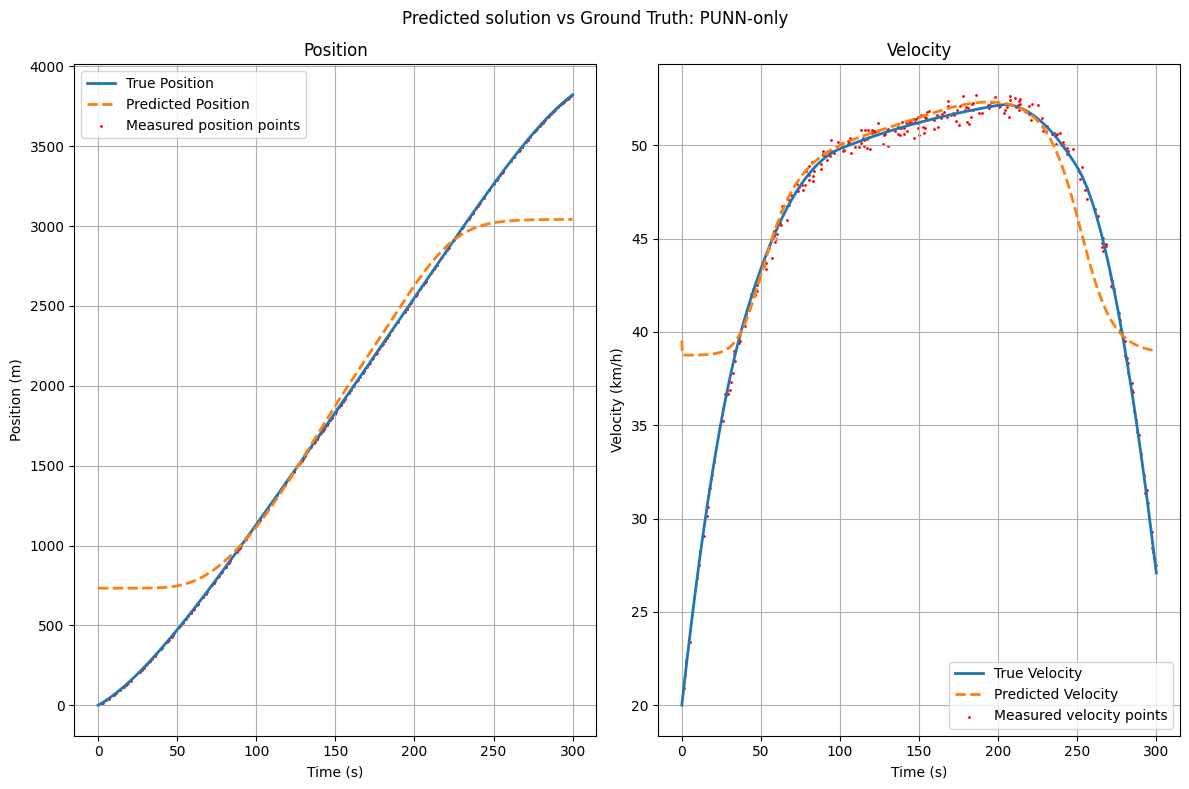

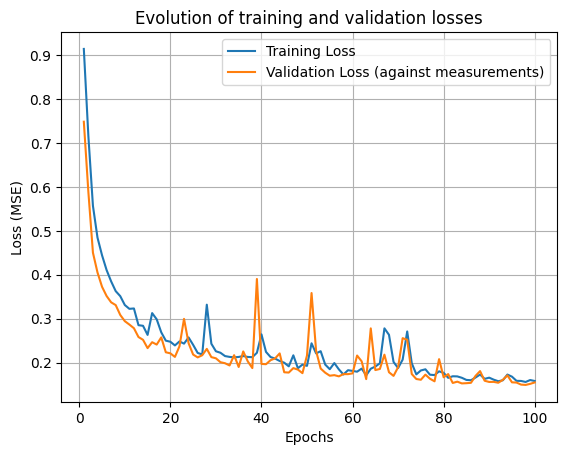

In [77]:
#predictions
predictions_norm = punn_model.predict(t)  # predictions shape will be (3000, 2)
predictions = predictions_norm * std_X_train + mean_X_train

comparison_plot(t, X_true, X_mask, predictions, "Predicted solution vs Ground Truth: PUNN-only")
loss_plot(history_punn_fwd.history, epochs)


### PINN

In [78]:
model.add_loss()

TypeError: Layer.add_loss() missing 1 required positional argument: 'loss'